In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from funciones_aux import imprimir_resultados, guardar_resultado_en_csv, RUTA_TRAIN, RUTA_TEST
import tensorflow as tf

2024-06-17 14:52:48.710101: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 14:52:48.713109: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 14:52:49.185007: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 14:52:51.008569: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df_train = pd.read_csv(RUTA_TRAIN)
df_test = pd.read_csv(RUTA_TEST)

In [3]:
df_train["sentimiento"] = df_train["sentimiento"].map({"positivo": 1, "negativo": 0})

In [4]:
RUTA_GUARDADO = "RED.csv"

In [5]:
df_train.head(5)

,Unnamed: 0,ID,review_es,sentimiento,idioma_detectado
0,0,0,Uno de los otros críticos ha mencionado que de...,1,es
1,1,1,Una pequeña pequeña producción.La técnica de f...,1,es
2,2,2,Pensé que esta era una manera maravillosa de p...,1,es
3,3,3,"Básicamente, hay una familia donde un niño peq...",0,es
4,4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",1,es


In [6]:
total_reviews = df_train["review_es"].astype(str)
total_labels = df_train["sentimiento"].values

In [7]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Entrenamiento")
    plt.plot(history.history["val_accuracy"], label="Validación")
    plt.title("Precisión del Modelo")
    plt.xlabel("Épocas")
    plt.ylabel("Precisión")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Entrenamiento")
    plt.plot(history.history["val_loss"], label="Validación")
    plt.title("Pérdida del Modelo")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.legend()

    plt.show()

In [8]:
Y_data = df_train.sentimiento

In [9]:
max_words = 5000
max_len = 100

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
tokenizer_obj = Tokenizer(num_words = max_words)
tokenizer_obj.fit_on_texts(total_reviews)

In [12]:
X_data_tokens = tokenizer_obj.texts_to_sequences(total_reviews)

In [13]:
X_data_count = tokenizer_obj.sequences_to_matrix(X_data_tokens, mode = "count")

In [14]:
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(X_data_count, Y_data, test_size = 0.3, random_state = 123)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorboard.plugins.hparams import api as hp

In [16]:
HP_INPUT_WIDTH = hp.HParam("input_width", hp.Discrete([12, 24, 48]))
HP_OUTPUT_WIDTH = hp.HParam("output_width", hp.Discrete([6, 12, 24]))  # No usaremos esto
HP_RNN_UNITS = hp.HParam("rnn_units", hp.Discrete([30, 40, 60]))
HP_DROPOUT = hp.HParam("dropout", hp.Discrete([0.05, 0.1, 0.2]))
HP_OPTIMIZER = hp.HParam("optimizer", hp.Discrete(["adam"]))
HP_LEARNING_RATE = hp.HParam("learning_rate", hp.Discrete([0.001]))

METRIC_ACCURACY = "accuracy"

In [17]:
def train_test_model(hparams):
    model = Sequential([
        Dense(hparams[HP_INPUT_WIDTH], activation='relu', input_shape=(max_words,)),
        Dropout(hparams[HP_DROPOUT]),
        Dense(hparams[HP_RNN_UNITS], activation='relu'),
        Dropout(hparams[HP_DROPOUT]),
        Dense(1, activation='sigmoid')  # Solo una unidad de salida para clasificación binaria
    ])
    
    optimizer = hparams[HP_OPTIMIZER]
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE])
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[METRIC_ACCURACY])
    
    model.fit(X_train_count, y_train_count, epochs=5, batch_size=32, validation_split=0.2)
    
    _, accuracy = model.evaluate(X_test_count, y_test_count)
    return accuracy

def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # log the hyperparameters
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
        return accuracy

# Diccionario para guardar los mejores hiperparámetros
best_hparams = None
best_accuracy = 0.0

session_num = 0

for input_width in HP_INPUT_WIDTH.domain.values:
    for output_width in HP_OUTPUT_WIDTH.domain.values:
        for rnn_units in HP_RNN_UNITS.domain.values:
            for dropout in HP_DROPOUT.domain.values:
                for optimizer in HP_OPTIMIZER.domain.values:
                    for learning_rate in HP_LEARNING_RATE.domain.values:
                        hparams = {
                            HP_INPUT_WIDTH: input_width,
                            HP_OUTPUT_WIDTH: output_width,
                            HP_RNN_UNITS: rnn_units,
                            HP_DROPOUT: dropout,
                            HP_OPTIMIZER: optimizer,
                            HP_LEARNING_RATE: learning_rate,
                        }
                        run_name = "run-%d" % session_num
                        print('--- Starting trial: %s' % run_name)
                        print({h: hparams[h] for h in hparams})
                        accuracy = run('logs/hparam_tuning/' + run_name, hparams)
                        if accuracy > best_accuracy:
                            best_accuracy = accuracy
                            best_hparams = hparams
                        session_num += 1

print(f'Best hyperparameters: {best_hparams}')
print(f'Best accuracy: {best_accuracy}')

--- Starting trial: run-0
{HParam(name='input_width', domain=Discrete([12, 24, 48]), display_name=None, description=None): 12, HParam(name='output_width', domain=Discrete([6, 12, 24]), display_name=None, description=None): 6, HParam(name='rnn_units', domain=Discrete([30, 40, 60]), display_name=None, description=None): 30, HParam(name='dropout', domain=Discrete([0.05, 0.1, 0.2]), display_name=None, description=None): 0.05, HParam(name='optimizer', domain=Discrete(['adam']), display_name=None, description=None): 'adam', HParam(name='learning_rate', domain=Discrete([0.001]), display_name=None, description=None): 0.001}


/home/taiel/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


2024-06-17 14:53:41.253081: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 539620000 exceeds 10% of free system memory.


824/844 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7768 - loss: 0.4709

2024-06-17 14:53:45.009434: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134920000 exceeds 10% of free system memory.


844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7783 - loss: 0.4686 - val_accuracy: 0.8733 - val_loss: 0.3131
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9054 - loss: 0.2442 - val_accuracy: 0.8719 - val_loss: 0.3042
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9285 - loss: 0.1869 - val_accuracy: 0.8673 - val_loss: 0.3266
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9426 - loss: 0.1484 - val_accuracy: 0.8633 - val_loss: 0.3625
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9584 - loss: 0.1137 - val_accuracy: 0.8648 - val_loss: 0.4253


2024-06-17 14:53:50.257396: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 289100000 exceeds 10% of free system memory.


452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.8644 - loss: 0.4143
--- Starting trial: run-1
{HParam(name='input_width', domain=Discrete([12, 24, 48]), display_name=None, description=None): 12, HParam(name='output_width', domain=Discrete([6, 12, 24]), display_name=None, description=None): 6, HParam(name='rnn_units', domain=Discrete([30, 40, 60]), display_name=None, description=None): 30, HParam(name='dropout', domain=Discrete([0.05, 0.1, 0.2]), display_name=None, description=None): 0.1, HParam(name='optimizer', domain=Discrete(['adam']), display_name=None, description=None): 'adam', HParam(name='learning_rate', domain=Discrete([0.001]), display_name=None, description=None): 0.001}
Epoch 1/5


2024-06-17 14:53:52.937613: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 539620000 exceeds 10% of free system memory.


839/844 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7757 - loss: 0.4803

2024-06-17 14:53:55.148089: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134920000 exceeds 10% of free system memory.


844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7762 - loss: 0.4796 - val_accuracy: 0.8678 - val_loss: 0.3084
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9022 - loss: 0.2502 - val_accuracy: 0.8731 - val_loss: 0.2981
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9253 - loss: 0.1907 - val_accuracy: 0.8724 - val_loss: 0.3325
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9430 - loss: 0.1524 - val_accuracy: 0.8696 - val_loss: 0.3738
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9503 - loss: 0.1250 - val_accuracy: 0.8658 - val_loss: 0.3976
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - accuracy: 0.8652 - loss: 0.3866
--- Starting trial: run-2
{HParam(name='input_width', domain=Discrete([12, 24, 48]), display_name=None, description=None): 12, HParam(name='output_width', domain=Discrete([6, 12, 24]), display_name=None, description=None): 6, HParam(name='rnn_units', domain=Discrete([30, 40, 60]), display_name=Non

In [27]:
# Entrenar un nuevo modelo con los mejores hiperparámetros
best_model = Sequential([
    Dense(best_hparams[HP_INPUT_WIDTH], activation='relu', input_shape=(max_words,)),
    Dropout(best_hparams[HP_DROPOUT]),
    Dense(best_hparams[HP_RNN_UNITS], activation='relu'),
    Dropout(best_hparams[HP_DROPOUT]),
    Dense(1, activation='sigmoid')
])

optimizer = best_hparams[HP_OPTIMIZER]
if optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_hparams[HP_LEARNING_RATE])

best_model.compile(optimizer=optimizer,
                   loss='binary_crossentropy',
                   metrics=[METRIC_ACCURACY])

best_model.fit(X_train_count, y_train_count, epochs=5, batch_size=32, validation_split=0.2)

8599
14455
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4896 - loss: 0.7011 - val_accuracy: 0.5128 - val_loss: 0.6927
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5273 - loss: 0.6910 - val_accuracy: 0.5047 - val_loss: 0.6944
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5640 - loss: 0.6816 - val_accuracy: 0.5105 - val_loss: 0.6950
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6032 - loss: 0.6563 - val_accuracy: 0.5017 - val_loss: 0.7221
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6670 - loss: 0.6052 - val_accuracy: 0.5110 - val_loss: 0.7434


In [16]:
model_count = Sequential()
model_count.add(Dense(100, activation="relu", input_shape=(5000,)))
model_count.add(Dense(25, activation="relu"))
model_count.add(Dense(1, activation="sigmoid"))

model_count.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

/home/taiel/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
history_count = model_count.fit(X_train_count, y_train_count, batch_size = 256, epochs = 15, validation_split=0.3)

Epoch 1/15


2024-06-17 12:52:03.548584: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 472160000 exceeds 10% of free system memory.


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7642 - loss: 0.5078 - val_accuracy: 0.8742 - val_loss: 0.3170
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9106 - loss: 0.2401 - val_accuracy: 0.8689 - val_loss: 0.3296
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9309 - loss: 0.1901 - val_accuracy: 0.8667 - val_loss: 0.3418
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9458 - loss: 0.1548 - val_accuracy: 0.8599 - val_loss: 0.3949
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9688 - loss: 0.0983 - val_accuracy: 0.8635 - val_loss: 0.4254
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9866 - loss: 0.0530 - val_accuracy: 0.8578 - val_loss: 0.5300
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9968 - loss: 0.0206 - val_accuracy: 0.8592 - val_loss: 0.5904
Epoch 8/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9993 - loss: 0.0079 - val_accuracy: 0.8607 - val_loss: 0.6549
Epo

In [18]:
test_loss, test_acc = model_count.evaluate(X_test_count, y_test_count)
print()
print(test_loss, test_acc)

452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.8666 - loss: 0.7969

0.8455109000205994 0.8638533353805542


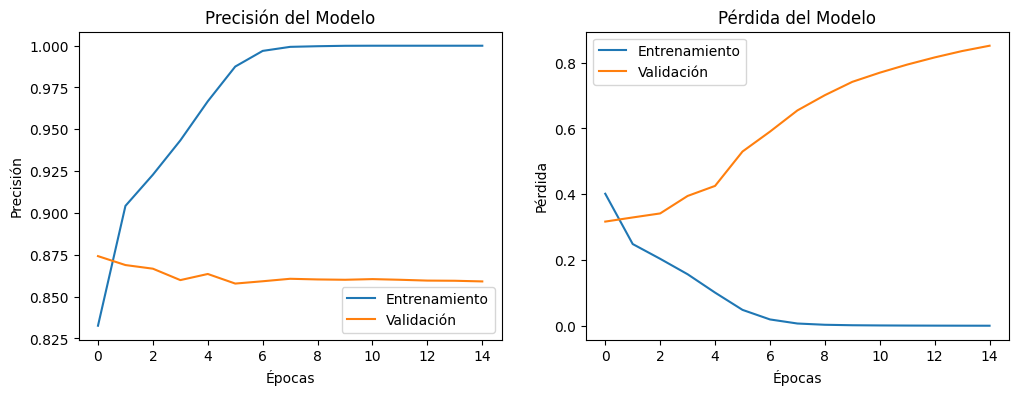

In [19]:
plot_training_history(history_count)

In [28]:
X_train_tokens = tokenizer_obj.texts_to_sequences(df_test["review_es"])
X_train_count = tokenizer_obj.sequences_to_matrix(X_train_tokens, mode = "count")
y_pred = best_model.predict(X_test_count)
y_pred = np.round(y_pred)

269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step


In [29]:
imprimir_resultados(y_test_count, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [14455, 8599]

In [34]:
X_test_tokens = tokenizer_obj.texts_to_sequences(df_test["review_es"])
X_test_count = tokenizer_obj.sequences_to_matrix(X_test_tokens, mode = "count")
y_pred = best_model.predict(X_test_count)
y_pred = np.round(y_pred)

269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


In [23]:
y_pred

array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [35]:
y_pred = np.where(y_pred == 0, "negativo", "positivo")

In [36]:
df_predicciones = pd.DataFrame({"ID": df_test["ID"], "prediccion": y_pred.flatten()})

df_predicciones.to_csv(RUTA_GUARDADO, header=["ID", "sentimiento"], index=False)